In [1]:
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from model import EncoderCNN, DecoderRNN
from nlp_utils import clean_sentence
from PIL import Image
from vocabulary import Vocabulary
from collections import Counter

%matplotlib inline
#%load_ext autoreload
#%autoreload 2

In [2]:
cocoapi_dir = "C:/Users/ExplosiveTurkey/image_captioning"

# Defining a transform to pre-process the testing images.
transform_test = transforms.Compose(
    [
        transforms.Resize(256),  # smaller edge of image resized to 256
        transforms.RandomCrop(224),  # get 224x224 crop from random location
        transforms.RandomHorizontalFlip(),  # horizontally flip image with probability=0.5
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)


# Creating the data loader.
data_loader = get_loader(transform=transform_test, mode="test", cocoapi_loc=cocoapi_dir)

Vocabulary successfully loaded from vocab.pkl file!


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify the saved models to load.
encoder_file = "encoder-3.pkl"
decoder_file = "decoder-3.pkl"

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
encoder.eval()
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file), map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file), map_location=torch.device('cpu')))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(9955, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

Text(0.5, 0, ' a group of people standing around a bus.')

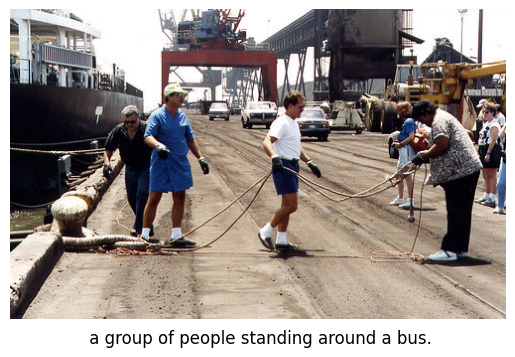

In [242]:
testimage=Image.open("./cocoapi/images/test/4.jpg").convert("RGB")
orig_image=np.array(testimage)
list = []
for x in range(1):
    image=transform_test(testimage)
    image=image.to(device)
    features = encoder(image[None,...]).unsqueeze(1)
    output = decoder.sample(features)
    list.append(output)
count = []
for x in list:
    no = 0
    for y in x:
        if (y!="a" or y!="an" or y!="the"):
            no+=sum(z.count(y) for z in list)-1
    count.append(no)
sentence = clean_sentence(list[count.index(max(count))], data_loader.dataset.vocab.idx2word)
ax = plt.axes()
# remove spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
# Hide ticks
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
plt.imshow(np.squeeze(orig_image))
plt.xlabel(sentence, fontsize=12)